In [1]:
#Script to make Galaxy Templates
#Templates are in lognuLnu vs lognu

In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
#from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
c = 299792458 #speed of light m s^-1

plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
z = 0.01813 #Redshift
zc = 0.018529 #corrected redshift related to CMB

fname = "ARP_220_S_Uv-MIr_bms2014.txt"

#lam is in observed now
lam,f =np.loadtxt(fname,comments="#", usecols=(2,1),unpack=True)

F = lam*f*1.e10

Lam = lam*1.e-4 #wavelength on microns

fname = "ARP_220_S_FIR_b2008.txt"

FIR_lam,FIR_f =np.loadtxt(fname,comments="#", usecols=(0,1),unpack=True)

#passing the lambda to emitted, since it is in rest frame, i.e. redshifting

FIR_lam = FIR_lam*(1.+z)

FIR_F = FIR_lam*FIR_f*10000000*1.e10

#extrapolation of both sides (initial and final)
FIR_lam_i = FIR_lam[0]-(FIR_lam[2]-FIR_lam[1])
FIR_F_i = FIR_F[0:5].mean()
#L = len(FIR_lam)
#FIR_lam_f = FIR_lam[L-1]+(FIR_lam[L-2]-FIR_lam[L-3])
#FIR_F_f = FIR_F[L-5:L-1].mean()

#FIR_F = np.concatenate((FIR_F_i,FIR_F,FIR_F_f),axis=None)
#FIR_lam = np.concatenate((FIR_lam_i,FIR_lam,FIR_lam_f),axis=None)

FIR_F = np.concatenate((FIR_F_i,FIR_F),axis=None)
FIR_lam = np.concatenate((FIR_lam_i,FIR_lam),axis=None)

mask_FIR = FIR_lam<185.
FIR_F = FIR_F[mask_FIR]
FIR_lam = FIR_lam[mask_FIR]

fname = "ARP_220_phot_NED.txt"

nu_phot,f_phot =np.loadtxt(fname,comments="#", usecols=(0,1),unpack=True)

F_phot0 = f_phot*1.e-23*nu_phot*1.e10
lam_phot0 = (c/nu_phot)*1.e6 

mask = lam_phot0>170.

F_phot = F_phot0[mask]
lam_phot = lam_phot0[mask]

F_phot_s = []
lam_phot_s = []

bins = np.logspace(2.23,6,40)
for i in range(len(bins)-1):
    mask0 = lam_phot > bins[i]
    mask1 = lam_phot < bins[i+1]
    mean_bin = (bins[i]+bins[i+1])/2.
    mask = mask0*mask1
    if len(F_phot[mask])>1:
        F_phot_s.append(F_phot[mask].mean())
        lam_phot_s.append(mean_bin)
    if len(F_phot[mask])==1:
        F_phot_s.append(F_phot[mask][0])
        lam_phot_s.append(mean_bin)
    if len(F_phot[mask]==0):
        pass

F_phot_s = np.asarray(F_phot_s)
lam_phot_s = np.asarray(lam_phot_s)

xs = np.logspace(2.26,6,500)
interp = np.interp(xs,lam_phot_s,F_phot_s)

logx = np.log(lam_phot_s)
logy = np.log(F_phot_s)
interp = UnivariateSpline(logx, logy)
interp.set_smoothing_factor(1.3)
yfit = lambda x: np.exp(interp(np.log(x)))


#getting nu L_nu

#merging the whole SED
lam_tot = np.concatenate((Lam,FIR_lam,xs),axis=None)
F_tot = np.concatenate((F,FIR_F,yfit(xs)),axis=None)

#calculating nuLnu using the corrected redshift related to CMB and 
#the Planck15 modelfor the calculation of the luminosity distance
nuLnu=F_tot*4*np.pi*Planck15.luminosity_distance(zc).value**2

#De-redshift 
lam_tot = lam_tot/(1.+z)

lognuLnu = np.log10(nuLnu)
loglam = np.log10(lam_tot)


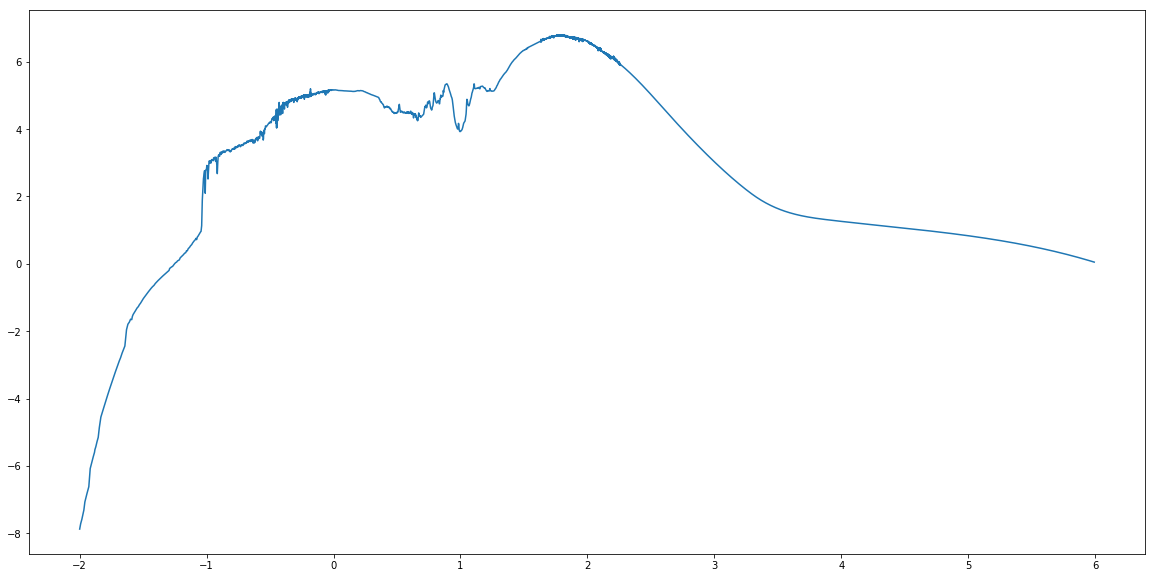

In [4]:
#Getting rid of annoying repeated values
#solution from https://stackoverflow.com/questions/29595085/python-numpy-replace-duplicate-values-with-mean-value

# x = Position Data
# y = Temperature Data
x = loglam
y = lognuLnu 

# Get correct order
idx = np.argsort(x)
x, y = x[idx], y[idx]
#plt.plot(x, y)  # Plot with multiple points at same location

# Calculate means for dupplicates
new_x = []
new_y = []
skip_next = False
for idx in range(len(x)):
    if skip_next:
        skip_next = False
        continue
    if idx < len(x)-1 and x[idx] == x[idx+1]:
        new_x.append(x[idx])
        new_y.append((y[idx] + y[idx+1]) / 2)
        skip_next = True
    else:
        new_x.append(x[idx])
        new_y.append(y[idx])
        skip_next = False

x, y = np.array(new_x), np.array(new_y)
plt.plot(x, y)  # Plots desired output
plt.show()

In [5]:
diffs = np.diff(x)
for i in range(len(diffs)):
    if diffs[i]>0:
        pass
    else:
        print i

4010


In [6]:
log_lam = np.delete(x,4010)
log_nuLnu = np.delete(y,4010)

In [7]:
X = np.linspace(-1.9,5.9,100000)
interp = interp1d(x,y)
Y = interp(X)

In [9]:
%matplotlib auto

Using matplotlib backend: TkAgg


In [11]:
plt.plot(X,Y,color="black")
plt.plot(x,y,"ro",markersize = 0.5)
plt.xlim(-1,2.5)
plt.ylim(2,7)
plt.show()

In [18]:
folder = "Templates"
name = "ARP220_loglam_lognuLnu.txt"
cwd = os.getcwd()
fullpath = cwd+"/"+folder+"/"+name
with open(fullpath,"w") as f:
    for i in range(len(X)):
        f.write("{} {}\n".format(X[i],Y[i]))